## Snowflake workflow

In [46]:
# https://towardsdatascience.com/exploring-bike-share-data-3e3b2f28760c
# https://medium.com/@jeffmarvel/forecasting-citibike-ridership-bdf72f97853a

In [4]:
import urllib
import zipfile
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import os

from dotenv import dotenv_values
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from dask.distributed import wait, LocalCluster, Client
from dask_snowflake import read_snowflake, to_snowflake

In [5]:
connection_kwargs = {
    k.replace("SNOWFLAKE_", "").lower(): v
    for k, v in dotenv_values(".env").items()
}

In [6]:
table_name = "citibike_tripdata"

## Create cluster and client

In [4]:
cluster = LocalCluster()

In [5]:
client = cluster.get_client()

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61619,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:61634,Total threads: 3
Dashboard: http://127.0.0.1:61640/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:61622,


## Read from Snowflake

In [7]:
ddf = read_snowflake(
    f"SELECT * FROM {table_name}", 
    connection_kwargs=snowflake_params, 
    npartitions=34
).rename(columns=str.lower)

In [10]:
ddf.head(3)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,is_member
0,716392A41D4693C3,classic_bike,2023-01-16 13:34:03,2023-01-16 13:40:35,E 5 St & Cooper Sq,5712,Broadway & E 21 St,6098,41,-74,41,-74,True
1,7EF2A2D2AB7D88E8,classic_bike,2023-01-26 18:17:55,2023-01-26 18:45:28,Vernon Blvd & 47 Rd,6212,Eastern Pkwy & Kingston Ave,3902,41,-74,41,-74,True
2,AAF82C99B0995DF4,classic_bike,2023-01-01 14:38:45,2023-01-01 14:59:23,5 Ave & E 93 St,7372,Central Park S & 6 Ave,6876,41,-74,41,-74,False


In [11]:
ddf["is_roundtrip"] = ddf["start_station_id"] == ddf["end_station_id"]

In [12]:
ddf.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               int16
end_station_name              object
end_station_id                 int16
start_lat                       int8
start_lng                       int8
end_lat                         int8
end_lng                         int8
is_member                       bool
is_roundtrip                    bool
dtype: object

In [13]:
roundtrips = ddf.is_roundtrip.value_counts().compute().reset_index(name="count")

In [14]:
roundtrips

,is_roundtrip,count
0,False,34119415
1,True,2280466


<Axes: xlabel='is_roundtrip', ylabel='count'>

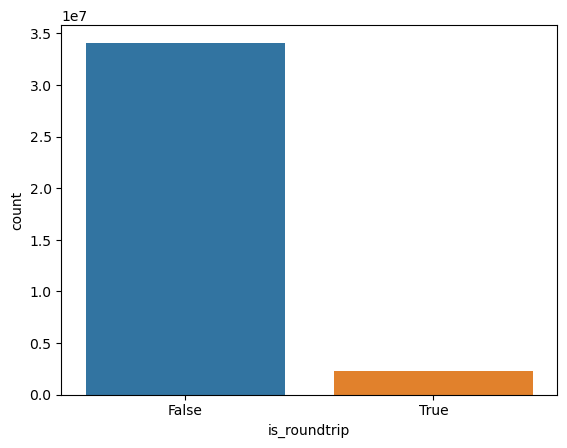

In [15]:
sns.barplot(roundtrips, x="is_roundtrip", y="count")

In [16]:
ddf["trip_duration"] = ddf["ended_at"] - ddf["started_at"]

In [35]:
ddf["trip_minutes"] = ddf["trip_duration"].dt.total_seconds() // 60

In [36]:
ddf["trip_minutes"].head(5)

0     6.0
1    27.0
2    20.0
3    14.0
4     9.0
Name: trip_minutes, dtype: float64

In [37]:
ddf.trip_minutes.dtype

dtype('float64')

In [38]:
ddf["trip_minutes"].describe().round(2).compute()

count    32911884.00
mean           11.79
std             8.59
min             2.00
25%             6.00
50%            10.00
75%            17.00
max            41.00
Name: trip_minutes, dtype: float64

In [39]:
duration_q = ddf["trip_minutes"].quantile([0.05, 0.95]).compute()

In [40]:
duration_q

0.05     3.0
0.95    32.0
Name: trip_minutes, dtype: float64

In [41]:
(duration_q[0.05], duration_q[0.95])

(3.0, 32.0)

In [42]:
ddf = ddf[(ddf["trip_minutes"] >= duration_q[0.05]) & (ddf["trip_minutes"] <= duration_q[0.95])]

In [43]:
durations = ddf["trip_minutes"].value_counts().compute()

In [44]:
durations = durations.reset_index(name="count").rename(columns={"index": "trip_minutes"})
durations

,trip_minutes,count
0,5.0,2411104
1,4.0,2382165
2,6.0,2318147
3,3.0,2162223
4,7.0,2158472
5,8.0,1975026
6,9.0,1791728
7,10.0,1610601
8,11.0,1443751
9,12.0,1288444


<Axes: xlabel='trip_minutes', ylabel='count'>

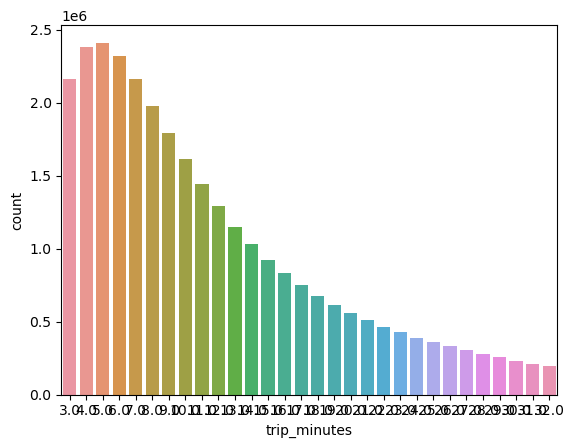

In [45]:
sns.barplot(durations, x="trip_minutes", y="count")

## Predict daily rides

In [53]:
daily = read_snowflake(
    f"""select date_trunc('day', started_at) as day, count(*) as count
        from {table_name}
        where started_at >= '2022-01-01'
        and started_at < '2023-01-01'
        group by 1
        order by 1""", 
    connection_kwargs=snowflake_params, 
    npartitions=200
).rename(columns=str.lower)

daily

,day,count
npartitions=1,,
,datetime64[ns],int64
,...,...


In [54]:
daily.head(5)

,day,count
0,2022-01-01,20665
1,2022-01-02,43423
2,2022-01-03,33387
3,2022-01-04,36902
4,2022-01-05,34533


<Axes: xlabel='day', ylabel='count'>

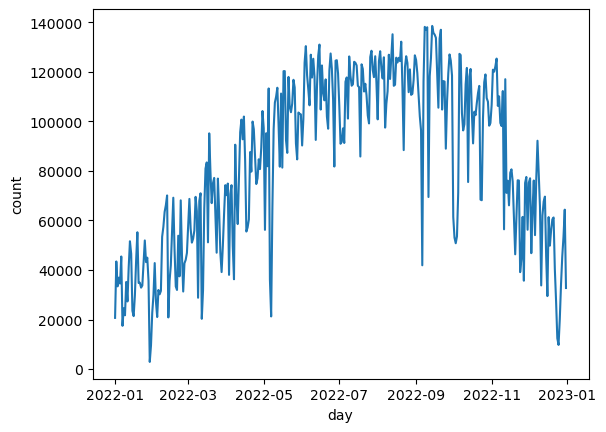

In [57]:
sns.lineplot(daily.compute(), x="day", y="count")

In [58]:
client.close()

In [59]:
cluster.close()